In [1]:
import sys
from typing import Any, Callable, Optional, Union
from pathlib import Path

from rdkit import Chem
from openff.units import unit

from openff.toolkit.utils import toolkit_registry
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper

from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import FrozenMolecule, Molecule

In [2]:
def generate_charged_molecule(pdbfile, substructure_file, toolkit_method='openeye'):
    # mol should already have one conformer...
    toolkits = {
        'openeye' : OpenEyeToolkitWrapper,
        'ambertools' : AmberToolsToolkitWrapper
    }

    off_topology, _, error = Topology.from_pdb_and_monomer_info(pdbfile, substructure_file, strict=True)
    # here, we assume that the topology only has ONE simple homopolymer. Later, all molecules can be extracted and charged
    mol = next(off_topology.molecules) # get the first molecule
    # get some conformers to run elf10 charge method. By default, `mol.assign_partial_charges`
    # uses 500 conformers, but we can generate and use 10 here for demonstration
    # mol.generate_conformers(
    #     n_conformers=10,
    #     rms_cutoff=0.25 * unit.angstrom,
    #     make_carboxylic_acids_cis=True,
    #     toolkit_registry=RDKitToolkitWrapper()
    # ) # very slow for large polymers! 

    # finally, assign partial charges using those 10 conformers generated 
    mol.assign_partial_charges(
        partial_charge_method='am1bcc', 
        toolkit_registry=toolkits.get(toolkit_method)()
    )
    # code for exact how the above function works can be found in openff/toolkit/utils/openeye_wrapper.py under the assign_partial_charges() function
    return mol

def fetch_charged_mol(filename : str, parent_path : Path=Path.cwd()/'compatible_pdbs', extensions=('pdb', 'json'), toolkit_method : str='openeye') -> Optional[Molecule]:
    ''''''
    mol_files = {
        ext : path
            for path in parent_path.glob('**/*.*')
                for ext in extensions
                    if path.name == f'{filename}.{ext}'
    }

    for ext in extensions:
        if ext not in mol_files:
            print(f'Could not find a(n) {ext} file \"{filename}.{ext}\"')
            return
            # sys.exit(0)
    else:
        charged_mol = generate_charged_molecule(str(mol_files['pdb']), mol_files['json'], toolkit_method=toolkit_method)
        print(f'final molecular charges: {charged_mol.partial_charges}')

        # note: the charged_mol has metadata about which monomers were assigned where
        # as a result of the chemicaly info assignment. This can be a way to break
        # up the molecule into repeating sections to partition the library charges 
        for atom in charged_mol.atoms:
            assert(atom.metadata['already_matched'] == True)
            print(atom.metadata['residue_name'])
        
        return charged_mol

In [3]:
cmol = fetch_charged_mol('naturalrubber', toolkit_method='openeye')

start
end
0 {'pos': [0.35950000000000004, 0.132, -0.0618], 'pdb_atom_id': 0, 'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C', 'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'already_matched': True, 'substructure_id': 0}
Formal charge: 0
1 {'pos': [0.3693, 0.2054, 0.019600000000000003], 'pdb_atom_id': 1, 'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'H', 'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'already_matched': True, 'substructure_id': 1}
Formal charge: 0
2 {'pos': [0.3643, 0.19110000000000002, -0.1553], 'pdb_atom_id': 2, 'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'H1', 'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'already_matched': True, 'substructure_id': 2}
Formal charge: 0
3 {'pos': [0.22460000000000002, 0.062, -0.054700000000000006], 'pdb_atom_id': 3, 'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C1', 'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'already_matched': True, 'substructu

final molecular charges: [-0.03956999988207277 0.04400999858131949 0.04400999858131949 -0.11754000172862467 -0.1667100040698951 0.11830999716272894 -0.06148999915370401 0.03898999854078833 0.03898999854078833 -0.06092999861487802 0.03940000026574675 0.03940000026574675 0.03940000026574675 0.03898999854078833 -0.03875000015744623 0.04459999888291899 0.04459999888291899 -0.11007999614724573 -0.16137999282130655 0.1184300036644036 -0.04427999989041742 0.04656000076880995 0.04656000076880995 -0.05877999947318491 0.04004000141373221 0.04004000141373221 0.04004000141373221 -0.040899999299139345 0.04746999978175703 0.04746999978175703 -0.11568000153550562 -0.16482000038871225 0.12092000260105673 -0.04434999809512552 0.0432399997030789 0.0432399997030789 -0.060299999871343934 0.04030999927869383 0.04030999927869383 0.04030999927869383 -0.04061999902972635 0.04380999892106596 0.04380999892106596 -0.10523000345477518 -0.17204999909648355 0.11647000177851263 -0.04408999890932497 0.046629998973518

In [46]:
str(cmol)

"Molecule with name '' and SMILES '[H]C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])C([H])([H])C(=C(C([H])([H])[H])C([H])([H])[H])[H])[H])[H])[H])[H])[H])[H])C([H])([H])[H]'"

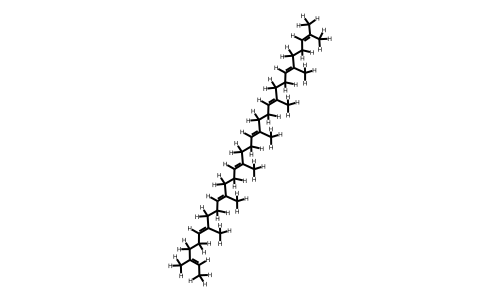

In [7]:
cmol.visualize()

In [50]:
for atom in cmol.atoms:
    print(atom.metadata)

{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'C', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'H', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'H1', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'C1', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'C2', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'H2', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'C3', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'H3', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residue_number': 0, 'atom_name': 'H4', 'already_matched': True}
{'residue_name': 'natural_rubber_TERM1', 'residu

In [44]:
import networkx as nx

G = nx.Graph()
G.add_node(0, val=6, attr='stuff')
G.add_node(3, val=7, attr='other')
G.nodes[3]['attr']

'other'

In [43]:
G.add_edge(1, 2, weight=10)
G.edges[1, 2]['weight']

10